Galaxy selected: MIlky_Way
Number of data points: 411

Statistics for Radius (kpc):
Mean: 10.30
Median: 10.30
Std Dev: 5.93
Min: 0.05
Max: 20.55
Skewness: -0.00
Kurtosis: -1.20

Statistics for Velocity (km/s):
Mean: 214.86
Median: 214.11
Std Dev: 12.41
Min: 194.84
Max: 252.24
Skewness: 0.24
Kurtosis: -0.52


Enter number of terms for polynomial model (2-10, default=3):  7



Fitting models...
Physical fit error: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (7,) + inhomogeneous part.
Basic NFW fit failed: Method 'lm' only works for unconstrained problems. Use 'trf' or 'dogbox' instead.
Full NFW fit failed: `x0` is infeasible.
Trying genetic algorithm...

Metrics for Polynomial Model:
R²: 0.8028
RMSE: 5.51 km/s
MSE: 30.35

Metrics for NFW Model:
R²: -1.9031
RMSE: 21.14 km/s
MSE: 446.82

Metrics for Isothermal Model:
R²: -1.3894
RMSE: 19.18 km/s
MSE: 367.76
Polynomial Model - AIC: 1416.6, BIC: 1444.8
NFW Model - AIC: 2516.0, BIC: 2532.1
Isothermal Model - AIC: 2432.0, BIC: 2440.0

 NFW Parameters:
ρ_s = 1.53e+08 M☉/kpc³
r_s = 5.52 kpc
v0 = 50.00 km/s
α = 0.72

Isothermal Density: ρ_0 = 8.85e+10 M☉/kpc³ (r_c = 0.10 kpc)

Physical model coefficients and contributions:
c_(-1) = 1.2081e+10  [linear r term] → 79.8% contribution
c_0    = -1.3943e+10  [constant term] → 12.3% cont

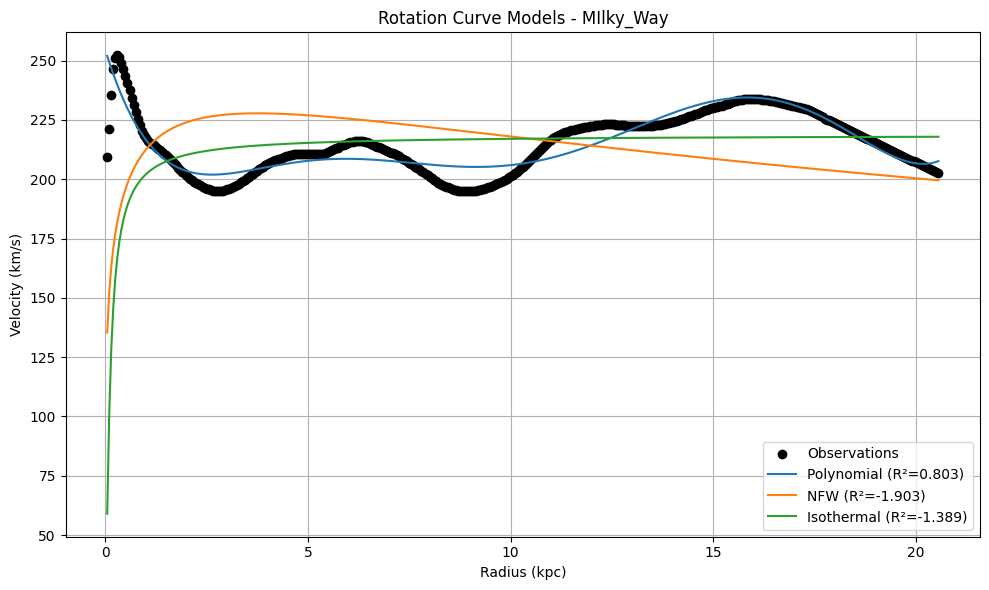

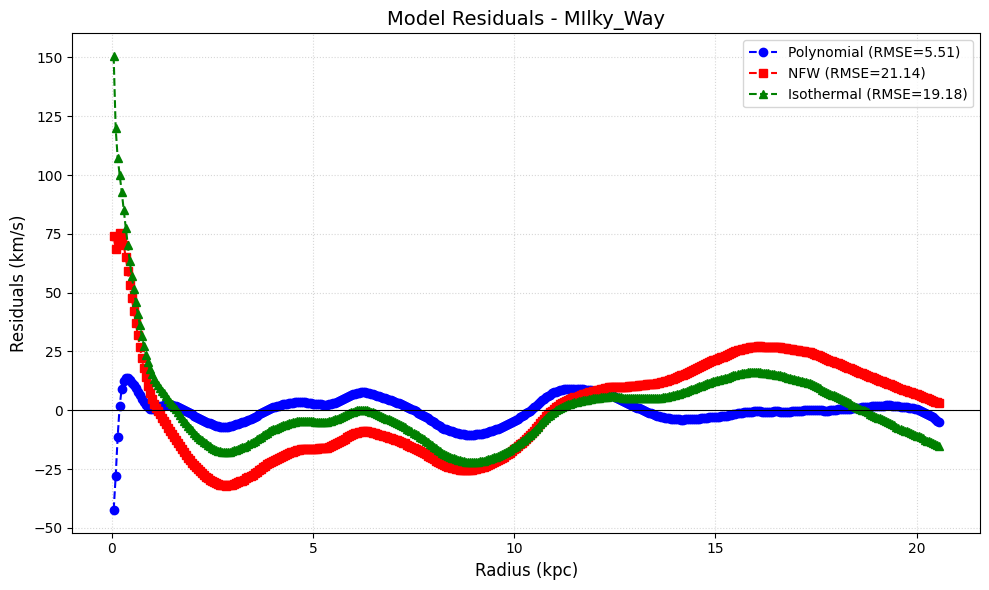


--- CONCLUSION ---
1. Best R²: Polynomial (0.803)
2. Lowest RMSE: Polynomial (5.51 km/s)
3. Best AIC: Polynomial (1416.6)
4. Best BIC: Polynomial (1444.8)

--- BEST OVERALL MODEL ---
Model Polynomial is the most suitable


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.constants import G as G_si
from scipy import stats
from sklearn.metrics import r2_score, mean_squared_error
from scipy.signal import find_peaks
from scipy.optimize import differential_evolution

# ==================== Complete galaxy dictionary ====================
galaxies = {
    1: 'NGC_6674',
    2: 'NGC_0224',
    3: 'NGC_0100',
    4: 'NGC_1705',
    5: 'NGC_3198',
    6: 'NGC_3672',
    7: 'UGC_03691',
    8: 'NGC_4321',
    9: 'NGC_4565',
    10: 'NGC_5055',
    11: 'NGC_5907',
    12: 'NGC_7331',
    13: 'NGC_6951',
    14: 'IC_342',
    15: 'NGC_1003',
    16: 'NGC_2403',
    17: 'NGC_4062',
    18: 'NGC_4096',
    19: 'NGC_4631',
    20: 'DDO_170',
    21: 'ESO_444_C084',
    22: 'F563_1',
    23: 'F571_8',
    24: 'NGC_0055',
    25: 'NGC_3972',
    26: 'NGC_4214',
    27: 'NGC_4271',
    28: 'NGC_4559',
    29: 'UGC_00731',
    30: 'UGC_05986',
    31: 'UGC_06786',
    32: 'UGC_06983',
    33: 'UGC_07524',
    34: 'UGC_07603',
    35: 'UGC_08286',
    36: 'UGC_08490',
    37: 'UGC_11455',
    38: 'UGC_11914',
    39: 'UGC_12506',
    40: 'UGC_12632',
    41: 'UGC_12732',
    42: 'UGC_A444',
    43: 'UGC_08490',
    44: 'NGC_3031',
    45: 'Milky_Way',
    46: 'IC_342',
    47: 'NGC_3628',
    48: 'NGC_4258',
    49: 'NGC_4303',
    50: 'NGC_4527',
    51: 'NGC_4569',
    52: 'NGC_4736',
    53: 'MIlky_Way'
}


# Select galaxy
selected_galaxy = 53
galaxy_name = galaxies.get(selected_galaxy, f"Unknown Galaxy {selected_galaxy}")

# ==================== CONSTANTS ====================
G_kpc = 4.30091e-6   # (kpc (km/s)^2)/M_sun
M_sun = 1.98847e30   # kg
kpc_to_m = 3.086e19  # kpc to meters

# ==================== DATA PROCESSING ====================
def load_data(data_string):
    """Load and process observational data with error handling"""
    lines = data_string.strip().split('\n')
    r_kpc, v_rot_kms = [], []

    for line in lines:
        try:
            cols = line.split()
            if len(cols) >= 2:  # Take first two columns only
                r = float(cols[0])
                v = float(cols[1])
                if r >= 0 and v >= 0:  # Add basic physical validation
                    r_kpc.append(r)
                    v_rot_kms.append(v)
        except (ValueError, IndexError) as e:
            print(f"Warning: Could not parse line '{line}': {e}")

    if not r_kpc or not v_rot_kms:
        raise ValueError("No valid data loaded")
    
    return np.array(r_kpc), np.array(v_rot_kms)

# ==================== STATISTICAL FUNCTIONS ====================
def calculate_statistics(data, name):
    """Calculate statistics with NaN handling"""
    if len(data) == 0 or np.all(np.isnan(data)):
        print(f"\nNo valid data for {name}")
        return None

    clean_data = data[~np.isnan(data)]
    if len(clean_data) == 0:
        return None

    stats_results = {
        "Mean": np.nanmean(data),
        "Median": np.nanmedian(data),
        "Std Dev": np.nanstd(data),
        "Min": np.nanmin(data),
        "Max": np.nanmax(data),
        "Skewness": stats.skew(clean_data) if len(clean_data) > 2 else np.nan,
        "Kurtosis": stats.kurtosis(clean_data) if len(clean_data) > 3 else np.nan
    }

    print(f"\nStatistics for {name}:")
    for key, value in stats_results.items():
        if np.isnan(value):
            print(f"{key}: N/A")
        else:
            print(f"{key}: {value:.2f}")
    
    return stats_results

def model_metrics(observed, predicted, model_name):
    """Calculate model metrics with robust error handling"""
    valid_mask = ~np.isnan(predicted)
    if not np.any(valid_mask):
        print(f"\nWarning: {model_name} model produced all NaN predictions")
        return float('-inf'), float('inf'), np.full_like(observed, np.nan)

    observed_clean = observed[valid_mask]
    predicted_clean = predicted[valid_mask]

    try:
        r2 = r2_score(observed_clean, predicted_clean)
        mse = mean_squared_error(observed_clean, predicted_clean)
        rmse = np.sqrt(mse)
        residuals = observed_clean - predicted_clean

        print(f"\nMetrics for {model_name}:")
        print(f"R²: {r2:.4f}")
        print(f"RMSE: {rmse:.2f} km/s")
        print(f"MSE: {mse:.2f}")

        return r2, rmse, residuals
    except Exception as e:
        print(f"Error calculating metrics for {model_name}: {e}")
        return float('-inf'), float('inf'), np.full_like(observed_clean, np.nan)

def calculate_aic_bic(n, k, residuals):
    """Calculate AIC and BIC with error handling"""
    try:
        rss = np.sum(residuals**2)
        if rss <= 0 or n <= 0:
            return float('inf'), float('inf')
            
        aic = n * np.log(rss / n) + 2 * k
        bic = n * np.log(rss / n) + k * np.log(n)
        return aic, bic
    except Exception as e:
        print(f"Error calculating AIC/BIC: {e}")
        return float('inf'), float('inf')

# ==================== MODEL DEFINITIONS ====================
class PhysicallyConstrainedPolynomial:
    def __init__(self, r_kpc, v_rot_kms):
        self.r = r_kpc
        self.v_obs = v_rot_kms
        self.safe_r = np.where(r_kpc == 0, 1e-10, r_kpc)
        self.params = None
        self.v_pred = None

    def mass_model(self, r, c_neg1, c_0, *c_n):
        """Physical mass model:
        M(r) = c_{-1}*r + c_0 + Σ c_n/r^n
        """
        r = np.where(r == 0, 1e-10, r)
        terms = [c_neg1 * r, c_0]
        for n, c in enumerate(c_n, start=1):
            terms.append(c / (r**n))
        return np.sum(terms, axis=0)

    def velocity_model(self, r, *coefficients):
        """Velocity derived from mass:
        v_rot = sqrt(G*M(r)/r)
        """
        M_r = self.mass_model(r, *coefficients)
        return np.sqrt(G_kpc * M_r / r)

    def fit(self, n_terms=3):
        """Physical fit with constraints"""
        try:
            # Intelligent initial estimate
            M_obs = (self.v_obs**2) * self.safe_r / G_kpc
            
            # Build design matrix for fit
            X = []
            X.append(self.safe_r)       # c_{-1}*r term
            X.append(np.ones_like(self.safe_r))  # c_0 term
            
            # Add c_n/r^n terms
            for n in range(1, n_terms-1):
                X.append(1/(self.safe_r**n))
            
            X = np.column_stack(X)
            
            # Weighted linear fit
            params, _, _, _ = np.linalg.lstsq(X, M_obs, rcond=None)
            
            self.params = params
            self.v_pred = self.velocity_model(self.safe_r, *params)
            
            # Physical constraints
            self.v_pred = np.clip(self.v_pred, 0, 2*np.max(self.v_obs))
            return self.v_pred
            
        except Exception as e:
            print(f"Physical fit error: {e}")
            # Fallback: empirical polynomial
            coeffs = np.polyfit(self.safe_r, self.v_obs, deg=n_terms-1)
            self.v_pred = np.polyval(coeffs, self.safe_r)
            return self.v_pred

    def print_coefficients(self):
        """Show physical coefficients with correct % contributions"""
        if self.params is None:
            print("Model not fitted!")
            return
            
        # Calculate mass contributions at all radii
        terms = []
        terms.append(self.params[0] * self.safe_r)  # c_-1*r term
        terms.append(np.full_like(self.safe_r, self.params[1]))  # c_0 term
        
        for n in range(2, len(self.params)):
            terms.append(self.params[n] / (self.safe_r**(n-1)))  # c_n/r^(n-1) terms
        
        # Convert to numpy array and calculate absolute contributions
        term_arrays = np.array(terms)
        abs_contributions = np.abs(term_arrays)
        total_mass = np.sum(abs_contributions, axis=0)
        
        # Calculate percentage contributions at each radius
        with np.errstate(divide='ignore', invalid='ignore'):
            pct_contributions = 100 * abs_contributions / total_mass
        
        # Average across all radii, ignoring invalid values
        avg_pct = np.nanmean(pct_contributions, axis=1)
        
        print("\nPhysical model coefficients and contributions:")
        print(f"c_(-1) = {self.params[0]:.4e}  [linear r term] → {avg_pct[0]:.1f}% contribution")
        print(f"c_0    = {self.params[1]:.4e}  [constant term] → {avg_pct[1]:.1f}% contribution")
        
        for n in range(2, len(self.params)):
            print(f"c_{n-1}  = {self.params[n]:.4e}  [1/r^{n-1} term] → {avg_pct[n]:.1f}% contribution")
            
class EnhancedNFWModel:
    def __init__(self, r_kpc, v_rot_kms):
        self.r = r_kpc
        self.v_obs = v_rot_kms
        self.params = None
        self.pcov = None
        self.v_pred = None
        
    def velocity_profile(self, r, rho_s, r_s, v0=0, alpha=1):
        """Improved NFW profile with additional parameters"""
        safe_r = np.maximum(r, 1e-10)
        x = safe_r / r_s
        log_arg = np.maximum(1 + x**alpha, 1e-10)
        term = np.log(log_arg) - x**alpha/(1 + x**alpha)
        M = 4 * np.pi * rho_s * r_s**3 * term
        v_nfw = np.sqrt(np.maximum(G_kpc * M / safe_r, 0))
        return np.sqrt(v_nfw**2 + v0**2)
    
    def smart_initial_guess(self):
        """Intelligent parameter estimation"""
        try:
            peaks, _ = find_peaks(self.v_obs, height=np.mean(self.v_obs))
            if len(peaks) > 0:
                v_max = self.v_obs[peaks[0]]
                r_max = self.r[peaks[0]]
            else:
                v_max = np.max(self.v_obs)
                r_max = self.r[np.argmax(self.v_obs)]
            
            r_s_guess = r_max / 2.163
            rho_s_guess = (v_max**2)/(4*np.pi*G_kpc*r_s_guess**2) * 1.3
            return [rho_s_guess, r_s_guess, 10, 1]
        except:
            return [1e6, 10, 10, 1]
        
    def robust_fit(self, method='lm'):
        """Robust fitting with multiple strategies"""
        try:
            # First try with basic parameters
            p0 = self.smart_initial_guess()[:2]
            bounds = ([1e4, 0.01], [1e10, 100])
            
            self.params, self.pcov = curve_fit(
                lambda r, rho_s, r_s: self.velocity_profile(r, rho_s, r_s),
                self.r,
                self.v_obs,
                p0=p0,
                bounds=bounds,
                method=method,
                max_nfev=10000
            )
            
            # Extend parameters with defaults
            self.params = np.append(self.params, [10, 1])
            self.v_pred = self.velocity_profile(self.r, *self.params)
            return self.v_pred
            
        except Exception as e:
            print(f"Basic NFW fit failed: {e}")
            try:
                # Try with all parameters
                p0_extended = self.smart_initial_guess()
                bounds_extended = ([1e4, 0.01, 0, 0.5], [1e10, 100, 50, 1.5])
                
                self.params, self.pcov = curve_fit(
                    self.velocity_profile,
                    self.r,
                    self.v_obs,
                    p0=p0_extended,
                    bounds=bounds_extended,
                    method='trf',
                    max_nfev=10000
                )
                self.v_pred = self.velocity_profile(self.r, *self.params)
                return self.v_pred
                
            except Exception as e:
                print(f"Full NFW fit failed: {e}")
                print("Trying genetic algorithm...")
                try:
                    bounds = [(1e4, 1e10), (0.01, 100), (0, 50), (0.5, 1.5)]
                    result = differential_evolution(
                        lambda params: np.sum((self.v_obs - self.velocity_profile(self.r, *params))**2),
                        bounds=bounds,
                        maxiter=100,
                        popsize=15,
                        tol=0.1
                    )
                    self.params = result.x
                    self.v_pred = self.velocity_profile(self.r, *result.x)
                    return self.v_pred
                except Exception as e:
                    print(f"Genetic algorithm failed: {e}")
                    self.v_pred = np.full_like(self.v_obs, np.nan)
                    return self.v_pred

class IsothermalModel:
    def __init__(self, r_kpc, v_rot_kms):
        self.r = r_kpc
        self.v_obs = v_rot_kms
        self.params = None
        self.pcov = None
        self.v_pred = None

    def velocity_profile(self, r, v_inf, r_c):
        """Isothermal profile with safety checks"""
        safe_r = np.maximum(r, 1e-10)
        term = 1 - (r_c / safe_r) * np.arctan(safe_r / r_c)
        return v_inf * np.sqrt(np.maximum(term, 0))

    def fit(self):
        """Fit isothermal model with error handling"""
        try:
            # Get reasonable initial guesses
            v0_guess = np.median(self.v_obs[-5:])  # Use last few points for v_inf estimate
            r0_guess = np.median(self.r)/2  # Median radius as initial guess
            
            self.params, self.pcov = curve_fit(
                self.velocity_profile,
                self.r,
                self.v_obs,
                p0=[v0_guess, r0_guess],
                bounds=([50, 0.1], [300, 50]),
                maxfev=5000
            )
            self.v_pred = self.velocity_profile(self.r, *self.params)
            return self.v_pred
        except Exception as e:
            print(f"Isothermal fitting failed: {e}")
            self.v_pred = np.full_like(self.v_obs, np.nan)
            return self.v_pred

    def calculate_rho_0(self, v_inf, r_c):
        """Calculate ρ_0 with safety checks"""
        try:
            denom = 4 * np.pi * G_kpc * r_c**2
            if denom <= 0:
                raise ValueError("Negative denominator in ρ_0 calculation")
            return (v_inf**2) / denom
        except Exception as e:
            print(f"Error calculating ρ_0: {e}")
            return np.nan

# ==================== MAIN EXECUTION ====================
if __name__ == "__main__":
    # Load data
    data_string = """    0.05000   209.55406
     0.10000   221.17062
     0.15000   235.59671
     0.20000   246.31863
     0.25000   251.17328
     0.30000   252.23865
     0.35000   251.37070
     0.40000   249.16048
     0.45000   246.26276
     0.50000   243.31323
     0.55000   240.47087
     0.60000   237.44099
     0.65000   234.32184
     0.70000   231.27351
     0.75000   228.22401
     0.80000   225.36021
     0.85000   222.84642
     0.90000   220.51955
     0.95000   218.56766
     1.00000   217.21397
     1.05000   216.18442
     1.10000   215.39040
     1.15000   214.79504
     1.20000   214.23282
     1.25000   213.62454
     1.30000   212.92415
     1.35000   212.17770
     1.40000   211.43652
     1.45000   210.74290
     1.50000   210.03438
     1.55000   209.29282
     1.60000   208.50002
     1.65000   207.64754
     1.70000   206.74559
     1.75000   205.82294
     1.80000   204.91537
     1.85000   204.04976
     1.90000   203.23418
     1.95000   202.45992
     2.00000   201.71246
     2.05000   200.98337
     2.10000   200.27583
     2.15000   199.60184
     2.20000   198.97377
     2.25000   198.39645
     2.30000   197.86472
     2.35000   197.36772
     2.40000   196.89691
     2.45000   196.45235
     2.50000   196.04378
     2.55000   195.68622
     2.60000   195.39339
     2.65000   195.17314
     2.70000   195.02711
     2.75000   194.95390
     2.80000   194.95294
     2.85000   195.02635
     2.90000   195.17769
     2.95000   195.40749
     3.00000   195.70827
     3.05000   196.06334
     3.10000   196.45151
     3.15000   196.85565
     3.20000   197.26961
     3.25000   197.69888
     3.30000   198.15526
     3.35000   198.64874
     3.40000   199.18213
     3.45000   199.75072
     3.50000   200.34615
     3.55000   200.96124
     3.60000   201.59219
     3.65000   202.23717
     3.70000   202.89224
     3.75000   203.54716
     3.80000   204.18463
     3.85000   204.78485
     3.90000   205.33382
     3.95000   205.83002
     4.00000   206.28485
     4.05000   206.71587
     4.10000   207.13702
     4.15000   207.55231
     4.20000   207.95592
     4.25000   208.33818
     4.30000   208.69231
     4.35000   209.01807
     4.40000   209.32011
     4.45000   209.60336
     4.50000   209.86864
     4.55000   210.11095
     4.60000   210.32149
     4.65000   210.49086
     4.70000   210.61223
     4.75000   210.68282
     4.80000   210.70483
     4.85000   210.68671
     4.90000   210.64377
     4.95000   210.59598
     5.00000   210.56136
     5.05000   210.54816
     5.10000   210.55151
     5.15000   210.55832
     5.20000   210.55884
     5.25000   210.55833
     5.30000   210.58018
     5.35000   210.65723
     5.40000   210.81599
     5.45000   211.06339
     5.50000   211.38469
     5.55000   211.75313
     5.60000   212.14372
     5.65000   212.54259
     5.70000   212.94756
     5.75000   213.36166
     5.80000   213.78500
     5.85000   214.20999
     5.90000   214.62212
     5.95000   215.00490
     6.00000   215.34491
     6.05000   215.63364
     6.10000   215.86594
     6.15000   216.03709
     6.20000   216.14056
     6.25000   216.16806
     6.30000   216.11246
     6.35000   215.97234
     6.40000   215.75539
     6.45000   215.47762
     6.50000   215.15871
     6.55000   214.81635
     6.60000   214.46307
     6.65000   214.10612
     6.70000   213.74907
     6.75000   213.39326
     6.80000   213.03889
     6.85000   212.68547
     6.90000   212.33202
     6.95000   211.97720
     7.00000   211.61903
     7.05000   211.25443
     7.10000   210.87852
     7.15000   210.48427
     7.20000   210.06323
     7.25000   209.60817
     7.30000   209.11646
     7.35000   208.59200
     7.40000   208.04398
     7.45000   207.48318
     7.50000   206.91820
     7.55000   206.35361
     7.60000   205.79041
     7.65000   205.22760
     7.70000   204.66339
     7.75000   204.09560
     7.80000   203.52136
     7.85000   202.93652
     7.90000   202.33543
     7.95000   201.71245
     8.00000   201.06584
     8.05000   200.40317
     8.10000   199.74403
     8.15000   199.11653
     8.20000   198.54707
     8.25000   198.04913
     8.30000   197.61836
     8.35000   197.23743
     8.40000   196.88638
     8.45000   196.55196
     8.50000   196.23064
     8.55000   195.92664
     8.60000   195.64781
     8.65000   195.40285
     8.70000   195.19952
     8.75000   195.04321
     8.80000   194.93494
     8.85000   194.87061
     8.90000   194.84253
     8.95000   194.84325
     9.00000   194.86897
     9.05000   194.92102
     9.10000   195.00427
     9.15000   195.12413
     9.20000   195.28387
     9.25000   195.48355
     9.30000   195.72025
     9.35000   195.98843
     9.40000   196.28040
     9.45000   196.58739
     9.50000   196.90224
     9.55000   197.22273
     9.60000   197.55354
     9.65000   197.90477
     9.70000   198.28781
     9.75000   198.71063
     9.80000   199.17548
     9.85000   199.67972
     9.90000   200.21817
     9.95000   200.78490
    10.00000   201.37402
    10.05000   201.98041
    10.10000   202.60051
    10.15000   203.23317
    10.20000   203.87990
    10.25000   204.54446
    10.30000   205.23260
    10.35000   205.95171
    10.40000   206.70972
    10.45000   207.51273
    10.50000   208.36182
    10.55000   209.25136
    10.60000   210.16940
    10.65000   211.09958
    10.70000   212.02264
    10.75000   212.91817
    10.80000   213.76776
    10.85000   214.55965
    10.90000   215.29184
    10.95000   215.97079
    11.00000   216.60608
    11.05000   217.20392
    11.10000   217.76357
    11.15000   218.27820
    11.20000   218.73973
    11.25000   219.14424
    11.30000   219.49480
    11.35000   219.80022
    11.40000   220.07152
    11.45000   220.31903
    11.50000   220.55128
    11.55000   220.77489
    11.60000   220.99445
    11.65000   221.21242
    11.70000   221.42889
    11.75000   221.64175
    11.80000   221.84650
    11.85000   222.03633
    11.90000   222.20389
    11.95000   222.34453
    12.00000   222.46027
    12.05000   222.56107
    12.10000   222.66142
    12.15000   222.77322
    12.20000   222.89900
    12.25000   223.02980
    12.30000   223.14883
    12.35000   223.23804
    12.40000   223.28368
    12.45000   223.27895
    12.50000   223.22462
    12.55000   223.12936
    12.60000   223.00938
    12.65000   222.88548
    12.70000   222.77710
    12.75000   222.69633
    12.80000   222.64520
    12.85000   222.61797
    12.90000   222.60593
    12.95000   222.60156
    13.00000   222.60033
    13.05000   222.60007
    13.10000   222.60001
    13.15000   222.60001
    13.20000   222.60001
    13.25000   222.60002
    13.30000   222.60011
    13.35000   222.60059
    13.40000   222.60245
    13.45000   222.60835
    13.50000   222.62361
    13.55000   222.65637
    13.60000   222.71611
    13.65000   222.81024
    13.70000   222.94080
    13.75000   223.10344
    13.80000   223.28955
    13.85000   223.49004
    13.90000   223.69827
    13.95000   223.91132
    14.00000   224.12978
    14.05000   224.35770
    14.10000   224.60193
    14.15000   224.87022
    14.20000   225.16743
    14.25000   225.49104
    14.30000   225.82973
    14.35000   226.16702
    14.40000   226.48898
    14.45000   226.79134
    14.50000   227.08122
    14.55000   227.37253
    14.60000   227.67743
    14.65000   227.99980
    14.70000   228.33385
    14.75000   228.66795
    14.80000   228.99042
    14.85000   229.29355
    14.90000   229.57466
    14.95000   229.83481
    15.00000   230.07732
    15.05000   230.30688
    15.10000   230.52943
    15.15000   230.75227
    15.20000   230.98454
    15.25000   231.23654
    15.30000   231.51657
    15.35000   231.82576
    15.40000   232.15367
    15.45000   232.47894
    15.50000   232.77652
    15.55000   233.02803
    15.60000   233.22888
    15.65000   233.38763
    15.70000   233.51868
    15.75000   233.63359
    15.80000   233.73619
    15.85000   233.82274
    15.90000   233.88550
    15.95000   233.91634
    16.00000   233.90904
    16.05000   233.86098
    16.10000   233.77501
    16.15000   233.66125
    16.20000   233.53589
    16.25000   233.41579
    16.30000   233.31071
    16.35000   233.21825
    16.40000   233.12469
    16.45000   233.01266
    16.50000   232.86986
    16.55000   232.69446
    16.60000   232.49390
    16.65000   232.27953
    16.70000   232.06100
    16.75000   231.84370
    16.80000   231.62914
    16.85000   231.41672
    16.90000   231.20549
    16.95000   230.99471
    17.00000   230.78392
    17.05000   230.57271
    17.10000   230.36031
    17.15000   230.14513
    17.20000   229.92381
    17.25000   229.69040
    17.30000   229.43588
    17.35000   229.14941
    17.40000   228.82089
    17.45000   228.44366
    17.50000   228.01628
    17.55000   227.54327
    17.60000   227.03639
    17.65000   226.51558
    17.70000   226.00723
    17.75000   225.53700
    17.80000   225.11954
    17.85000   224.75145
    17.90000   224.41273
    17.95000   224.07671
    18.00000   223.72171
    18.05000   223.33813
    18.10000   222.92763
    18.15000   222.49763
    18.20000   222.05569
    18.25000   221.60677
    18.30000   221.15350
    18.35000   220.69818
    18.40000   220.24437
    18.45000   219.79710
    18.50000   219.36133
    18.55000   218.93929
    18.60000   218.52879
    18.65000   218.12363
    18.70000   217.71613
    18.75000   217.30057
    18.80000   216.87514
    18.85000   216.44199
    18.90000   216.00601
    18.95000   215.57364
    19.00000   215.15152
    19.05000   214.74477
    19.10000   214.35435
    19.15000   213.97501
    19.20000   213.59560
    19.25000   213.20308
    19.30000   212.78777
    19.35000   212.34731
    19.40000   211.88669
    19.45000   211.41554
    19.50000   210.94473
    19.55000   210.48427
    19.60000   210.04260
    19.65000   209.62555
    19.70000   209.23508
    19.75000   208.86868
    19.80000   208.52003
    19.85000   208.18031
    19.90000   207.83949
    19.95000   207.48753
    20.00000   207.11626
    20.05000   206.72192
    20.10000   206.30704
    20.15000   205.87949
    20.20000   205.44910
    20.25000   205.02339
    20.30000   204.60522
    20.35000   204.19319
    20.40000   203.78383
    20.45000   203.37411
    20.50000   202.96272
    20.55000   202.55000 """

    try:
        r_kpc, v_rot_kms = load_data(data_string)
        print(f"Galaxy selected: {galaxy_name}")
        print(f"Number of data points: {len(r_kpc)}")
        
        # Calculate statistics
        r_stats = calculate_statistics(r_kpc, "Radius (kpc)")
        v_stats = calculate_statistics(v_rot_kms, "Velocity (km/s)")
        
        # Initialize models
        models = {
            "Polynomial": PhysicallyConstrainedPolynomial(r_kpc, v_rot_kms),
            "NFW": EnhancedNFWModel(r_kpc, v_rot_kms),
            "Isothermal": IsothermalModel(r_kpc, v_rot_kms)
        }

        # Fit models
        try:
            n_terms = int(input("Enter number of terms for polynomial model (2-10, default=3): ") or 3)
            if n_terms < 2 or n_terms > 10:
                raise ValueError("Number of terms must be between 2 and 10")
        except ValueError as e:
            print(f"Invalid input: {e}. Using default n_terms=3")
            n_terms = 3

        print("\nFitting models...")
        v_poly = models["Polynomial"].fit(n_terms)
        v_nfw = models["NFW"].robust_fit()
        v_iso = models["Isothermal"].fit()

        # Calculate metrics
        metrics = {
            "Polynomial": model_metrics(v_rot_kms, v_poly, "Polynomial Model"),
            "NFW": model_metrics(v_rot_kms, v_nfw, "NFW Model"),
            "Isothermal": model_metrics(v_rot_kms, v_iso, "Isothermal Model")
        }
        
        # Calculate AIC/BIC
        n = len(v_rot_kms)
        aic_bic = {}
        for name, model in models.items():
            if model.v_pred is None or np.all(np.isnan(model.v_pred)):
                aic_bic[name] = (float('inf'), float('inf'))
                continue
                
            _, _, residuals = metrics[name]
            if name == "Polynomial":
                k = n_terms
            elif name == "NFW":
                k = len(model.params) if hasattr(model, 'params') and model.params is not None else 4
            else:
                k = 2
                
            aic, bic = calculate_aic_bic(len(residuals), k, residuals)
            aic_bic[name] = (aic, bic)
            print(f"{name} Model - AIC: {aic:.1f}, BIC: {bic:.1f}")

        # Density calculations
        if hasattr(models["NFW"], 'params') and models["NFW"].params is not None:
            try:
                rho_s, r_s, v0, alpha = models["NFW"].params
                print(f"\n NFW Parameters:")
                print(f"ρ_s = {rho_s:.2e} M☉/kpc³")
                print(f"r_s = {r_s:.2f} kpc")
                print(f"v0 = {v0:.2f} km/s")
                print(f"α = {alpha:.2f}")
            except Exception as e:
                print(f"\nError displaying NFW parameters: {e}")
        
        if hasattr(models["Isothermal"], 'params') and models["Isothermal"].params is not None:
            try:
                v_inf, r_c = models["Isothermal"].params
                rho_0 = models["Isothermal"].calculate_rho_0(v_inf, r_c)
                print(f"\nIsothermal Density: ρ_0 = {rho_0:.2e} M☉/kpc³ (r_c = {r_c:.2f} kpc)")
            except Exception as e:
                print(f"\nCould not calculate Isothermal density: {e}")

        # Print polynomial coefficients using the new method
        if hasattr(models["Polynomial"], 'print_coefficients'):
            models["Polynomial"].print_coefficients()
        
        # Plot rotation curve
        plt.figure(figsize=(10, 6))
        plt.plot(r_kpc, v_rot_kms, 'ko', label='Observations')
        for name, model in models.items():
            if model.v_pred is not None and not np.all(np.isnan(model.v_pred)):
                plt.plot(r_kpc, model.v_pred, label=f"{name} (R²={metrics[name][0]:.3f})")
        plt.xlabel('Radius (kpc)')
        plt.ylabel('Velocity (km/s)')
        plt.title(f'Rotation Curve Models - {galaxy_name}')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f'{galaxy_name.replace(" ", "_")}_rotation_curve.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Plot residuals with dashed lines
        plt.figure(figsize=(10, 6))
        # Define styles for each model
        styles = {
            "Polynomial": {'marker': 'o', 'linestyle': '--', 'color': 'blue'},
            "NFW": {'marker': 's', 'linestyle': '--', 'color': 'red'},
            "Isothermal": {'marker': '^', 'linestyle': '--', 'color': 'green'}
        }
        
        for name, model in models.items():
            if model.v_pred is not None and not np.all(np.isnan(model.v_pred)):
                residuals = v_rot_kms - model.v_pred
                plt.plot(r_kpc, residuals, 
                         label=f"{name} (RMSE={metrics[name][1]:.2f})",
                         **styles.get(name, {'marker': 'o', 'linestyle': '--'}))
                
        plt.axhline(0, color='k', linestyle='-', linewidth=0.8)
        plt.xlabel('Radius (kpc)', fontsize=12)
        plt.ylabel('Residuals (km/s)', fontsize=12)
        plt.title(f'Model Residuals - {galaxy_name}', fontsize=14)
        plt.legend(fontsize=10, loc='upper right')
        plt.grid(True, linestyle=':', alpha=0.5)
        plt.tight_layout()
        plt.savefig(f'{galaxy_name.replace(" ", "_")}_residuals_plot.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Conclusion
        print("\n--- CONCLUSION ---")
        active_metrics = {
            name: {
                'R2': metrics[name][0],
                'RMSE': metrics[name][1],
                'AIC': aic_bic[name][0],
                'BIC': aic_bic[name][1]
            }
            for name in models
            if not np.isinf(metrics[name][0])  # Only include models that were successfully fitted
        }

        if not active_metrics:
            print("No model was successfully fitted!")
        else:
            # Find best models for each metric
            best_R2 = max(active_metrics.keys(), key=lambda x: active_metrics[x]['R2'])
            best_RMSE = min(active_metrics.keys(), key=lambda x: active_metrics[x]['RMSE'])
            best_AIC = min(active_metrics.keys(), key=lambda x: active_metrics[x]['AIC'])
            best_BIC = min(active_metrics.keys(), key=lambda x: active_metrics[x]['BIC'])
            
            print(f"1. Best R²: {best_R2} ({active_metrics[best_R2]['R2']:.3f})")
            print(f"2. Lowest RMSE: {best_RMSE} ({active_metrics[best_RMSE]['RMSE']:.2f} km/s)")
            print(f"3. Best AIC: {best_AIC} ({active_metrics[best_AIC]['AIC']:.1f})")
            print(f"4. Best BIC: {best_BIC} ({active_metrics[best_BIC]['BIC']:.1f})")

            # Score models based on how often they appear as best
            scores = {model: 0 for model in active_metrics}
            for model in active_metrics:
                if model == best_R2: scores[model] += 1
                if model == best_RMSE: scores[model] += 1
                if model == best_AIC: scores[model] += 1
                if model == best_BIC: scores[model] += 1

            max_score = max(scores.values())
            best_models = [m for m, s in scores.items() if s == max_score]

            print("\n--- BEST OVERALL MODEL ---")
            if len(best_models) == 1:
                print(f"Model {best_models[0]} is the most suitable")
            else:
                # If tie, use R² as tie-breaker
                best_overall = max(best_models, key=lambda x: active_metrics[x]['R2'])
                print(f"Model {best_overall} selected by tie-breaker (best R²)")

    except Exception as e:
        print(f"Error in main execution: {e}")
        import traceback
        traceback.print_exc()